**PRIMER MÓDELO PREDICTIVO**

PUNTAJE 2.4062

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1G82lh1gbqdbHtwBwOD8f1Ic9r9fMnK9D#scrollTo=B8Dl-C8QrRox)

In [ ]:
#Subir credenciales de kaggle , en tu cuenta de kaggle ve a settings -> Create Token 
#Se descargara un archivo .json con tus credenciales
#Ese archivo es el que debes subir en este comando
from google.colab import files 
files.upload()


# **Descargar Datos desde Kaggle**

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c store-sales-time-series-forecasting

 61% 13.0M/21.4M [00:00<00:00, 136MB/s]
100% 21.4M/21.4M [00:00<00:00, 166MB/s]


In [ ]:
! unzip store-sales-time-series-forecasting.zip

Archive:  store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
replace oil.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
! rm store-sales-time-series-forecasting.zip
! rm kaggle.json

rm: cannot remove 'kaggle.json': No such file or directory


In [ ]:
path=''

# **Data**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import plotly.express as px 

In [ ]:

# Load train
train_data = pd.read_csv(path+'train.csv', parse_dates=['date'], infer_datetime_format=True) # columna date a tipo fecha
# Load Test
test_data = pd.read_csv(path+'test.csv', parse_dates=['date'], infer_datetime_format=True) # columna date a tipo fecha
#Load stores
stores_data = pd.read_csv(path+'stores.csv')
#Load oil 
oil_data = pd.read_csv(path+'oil.csv',parse_dates=['date'], infer_datetime_format=True)
#Load holidays
holiday_data= pd.read_csv(path+'holidays_events.csv')

# **ANALISIS**

## **Train**

In [ ]:
# Cuantas tiendas , productos y fechas hay en el dataset

print('Stores : ',train_data['store_nbr'].unique().__len__()) # 54 stores
print('Families : ',train_data['family'].unique().__len__()) # 33 products

print('Dias en train data : ',len(train_data) / 54 / 33) # 1684 days (between 4 and 5 years)
print('Fecha Inicial Train : ',train_data['date'].iloc[0]) # 2013-01-01 is start
print('Fecha Final Train : ',train_data['date'].iloc[-1]) # 2017-08-15 is end

print('Dias en test data : ',len(test_data) / 54 / 33) # 16 days
print('Fecha Inicial Test : ',test_data['date'].iloc[0]) # 2017-08-16 is test start
print('Fecha Final Test : ',test_data['date'].iloc[-1]) # 2017-08-31 is test test_df

print('Registros totales en train : ',train_data['id'].unique().__len__())
print('Registros totales en Test : ',test_data['id'].unique().__len__())

Stores :  54
Families :  33
Dias en train data :  1684.0
Fecha Inicial Train :  2013-01-01 00:00:00
Fecha Final Train :  2017-08-15 00:00:00
Dias en test data :  16.0
Fecha Inicial Test :  2017-08-16 00:00:00
Fecha Final Test :  2017-08-31 00:00:00
Registros totales en train :  3000888
Registros totales en Test :  28512


Podemos observar que tanto los datos en Train como Test se distribuyen de la siguiente manera : 
Tenemos 33 familias de productos , en 54 tiendas con un registro de ventas en 1684 dias (desde la fecha inicial hasta la fecha final del dataset ) , esto es 33*54*1684 = 3000888 registros .
Cada registro representa la venta de un producto (familia) en una tienda especifica (store_nbr) en un dia (date) , los datos estan entre 2013-2017

In [ ]:
data = train_data.copy()
data = data.set_index("date").to_period('D')
data = data.groupby('date').agg({'sales':'mean'})
#Grafica interactiva 
data =data.iloc[1:, :].reset_index()
data['date']=data['date'].apply(lambda x: x.to_timestamp())
# data

fig = px.line(
    data_frame = data,
    x      = 'date',
    y      = 'sales', 
    title  = 'Ventas diarias',
    width  = 900,
    height = 500
)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

La grafica anterior de ventas diaras , nos da un indicio de que hay un patron de ventas dependiendo del los dias

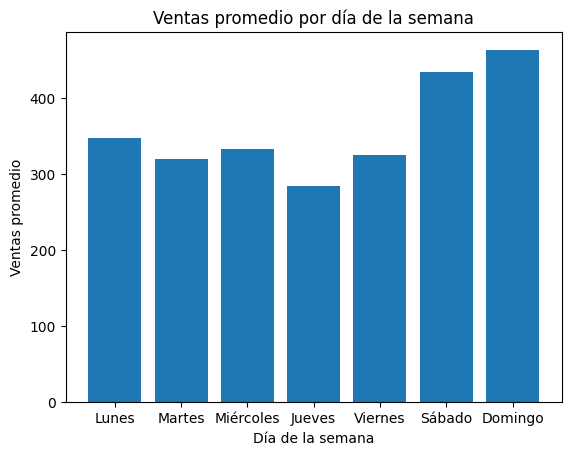

In [ ]:
data = train_data.copy()
data['day_of_week'] = data['date'].dt.weekday
sales_by_day = data.groupby('day_of_week')['sales'].mean()

# Crear un gráfico de barras para visualizar las ventas por día de la semana
plt.bar(sales_by_day.index, sales_by_day.values)
plt.xticks(range(7), ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'])
plt.xlabel('Día de la semana')
plt.ylabel('Ventas promedio')
plt.title('Ventas promedio por día de la semana')
plt.show()

por lo general los fines de semana son los dias de mas ventas , lo que indica que una buena caracteristica por añadir al dataset podria ser el dia de la semana 

## Stores 

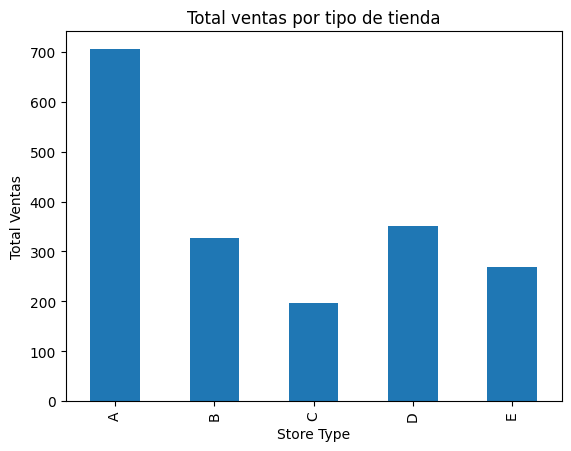

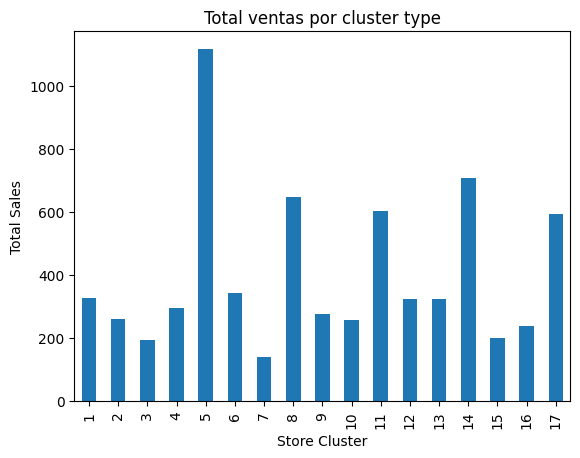

In [ ]:
#Grafica relacion entre stores y train
train_data = pd.merge(train_data, stores_data, on='store_nbr', how='left')
sales_by_type = train_data.groupby(['type'])['sales'].mean()
sales_by_type.plot(kind='bar')
plt.xlabel('Store Type')
plt.ylabel('Total Ventas')
plt.title('Total ventas por tipo de tienda')
plt.show()
sales_by_cluster = train_data.groupby('cluster')['sales'].mean()
sales_by_cluster.plot(kind='bar')
plt.xlabel('Store Cluster')
plt.ylabel('Total Sales')
plt.title('Total ventas por cluster type')
plt.show()

Se observa una fuerte relacion entre las tiendas y el promedio de ventas , dado que esto puede afectar en la prediccion se tendra en cuenta los datos de stores , para esto combinamos los dataframe para tener ambos datos, se hace el mismo proceso con test  

## Oil

Correlation with Daily Oil Prices
-0.07905016021992754 



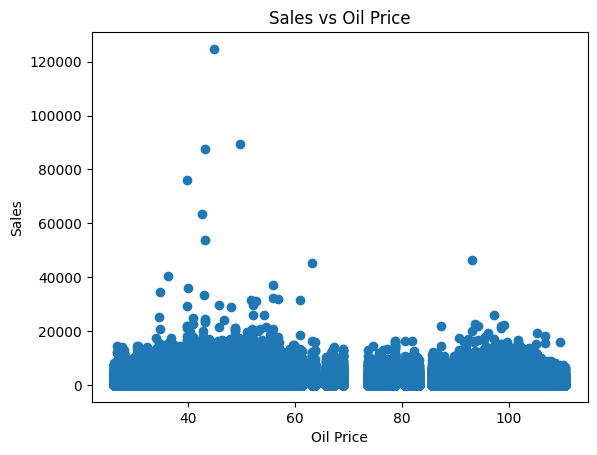

In [ ]:

merged = pd.merge(train_data, oil_data, on='date', how='left')

print("Correlation with Daily Oil Prices")
print((merged['dcoilwtico']).corr(merged["sales"]), "\n")

# Create scatter plot of sales versus oil price
plt.scatter(merged['dcoilwtico'], merged['sales'])
plt.xlabel('Oil Price')
plt.ylabel('Sales')
plt.title('Sales vs Oil Price')
plt.show()

Se tiene una correlacion entre las ventas diarias y el precio del petroleo de (-0.079), al ser negativo indica que las ventas diarias desminuyen cuando el precio del petroleo aumenta pero no es una relacion fuerte , inicialmente no se tendra en cuenta este archivo , pero se tendra en cuenta para futuros cambios al modelo


In [ ]:
# Merge the oil price data with the training and test data
# train_data = pd.merge(train_data, oil_data, on='date', how='left')
# test_data = pd.merge(test_data, oil_data, on='date', how='left')

# **MODELO**

## Organizando y limpiando datos

In [ ]:
# Feature Engineering
# Separando date en sus componentes dia , mes .año y dia de la semana
train_data['date'] = pd.to_datetime(train_data['date'])
train_data['day_of_week'] = train_data['date'].dt.dayofweek
train_data['month'] = train_data['date'].dt.month
train_data['year'] = train_data['date'].dt.year

test_data['date'] = pd.to_datetime(test_data['date'])
test_data['day_of_week'] = test_data['date'].dt.dayofweek
test_data['month'] = test_data['date'].dt.month
test_data['year'] = test_data['date'].dt.year

In [ ]:
# train_data['dcoilwtico'] = train_data['dcoilwtico'].fillna(0)
# train_data['onpromotion'] =train_data['onpromotion'].fillna(0)
# test_data['dcoilwtico'] = test_data['dcoilwtico'].fillna(0)
# test_data['onpromotion'] =test_data['onpromotion'].fillna(0)

In [ ]:
# Merge 
# Merge de train y test con stores
train_data = pd.merge(train_data, stores_data, on='store_nbr', how='left')
test_data = pd.merge(test_data, stores_data, on='store_nbr', how='left')

In [ ]:
# Codificando variables categoricas
train_data = pd.get_dummies(train_data, columns=['family', 'type', 'city', 'state', 'cluster'])
test_data = pd.get_dummies(test_data, columns=['family', 'type', 'city', 'state', 'cluster'])


In [ ]:
# nan data validation
test_data.isna().any().any()

False

In [ ]:
pd.set_option('display.max_columns', 1000)
train_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000888 entries, 0 to 3000887
Columns: 101 entries, id to cluster_17
dtypes: datetime64[ns](1), float64(1), int64(6), uint8(93)
memory usage: 472.2 MB


In [ ]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data.drop(['date', 'sales'], axis=1), train_data['sales'], test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2400710, 99), (600178, 99), (2400710,), (600178,))

In [ ]:

# Train a Random Forest Regression model
model = RandomForestRegressor(n_estimators=50,max_depth=5, random_state=42)


In [ ]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=50, random_state=42)

In [ ]:
# Make predictions on the validation set
y_val_pred = model.predict(X_val)

In [ ]:

# Calculate the RMSLE of the predictions
rmsle_score = np.sqrt(mean_squared_error(np.log1p(y_val), np.log1p(y_val_pred)))
print('RMSLE: ', rmsle_score)

RMSLE:  3.0268838048116176


In [ ]:
# Make predictions on the test data
X_test = test_data.drop([ 'date'], axis=1)
y_test_pred = model.predict(X_test)

In [ ]:
y_test_pred

array([  89.79863349,   89.79863349,   89.79863349, ..., 2550.25112343,
         89.79863349,   89.79863349])

In [ ]:

# Create a submission file
# submission = pd.DataFrame({'id': test_data['id'], 'sales': y_test_pred})
# submission.to_csv('submission.csv', index=False)